In [1]:
import os
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pprint import pprint
from IPython.display import clear_output

In [2]:
!pip3 uninstall tensorflow-gpu==2.0.0-beta0
!pip3 uninstall -y tensorflow
!pip3 uninstall keras
clear_output()

In [3]:
!pip3 uninstall tensorflow-gpu==2.0.0-beta0
!pip3 install tensorflow-gpu==2.0.0-beta0
!pip3 uninstall tensorflow
!pip3 install tensorflow
clear_output()

In [4]:
!pip3 uninstall tensorflow-datasets
!pip3 install tensorflow-datasets
clear_output()

In [5]:
!pip3 install --ignore-installed --upgrade --ignore-installed tensorflow
clear_output()

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!pip3 install tensorflow-gpu==2.0.0-beta0
import tensorflow as tf
import tensorflow_datasets as tfds

clear_output()
print(tf.__version__)

2.6.0


In [8]:
import logging
logging.basicConfig(level="ERROR")

np.set_printoptions(suppress=True)

In [10]:
output_dir = "/content/drive/My Drive/nmt"
if not os.path.exists(output_dir):
  os.makedirs(output_dir)

en_vocab_file = os.path.join(output_dir, "en_vocab")
zh_vocab_file = os.path.join(output_dir, "zh_vocab")
checkpoint_path = os.path.join(output_dir, "checkpoints")
log_dir = os.path.join(output_dir, 'logs')
download_dir = "/content/drive/My Drive/tensorflow-datasets/downloads"


In [11]:
#下載資料集
tmp_builder = tfds.builder("wmt19_translate/zh-en")
print(tmp_builder.subsets)

{Split('train'): ['newscommentary_v14',
                  'wikititles_v1',
                  'uncorpus_v1',
                  'casia2015',
                  'casict2011',
                  'casict2015',
                  'datum2015',
                  'datum2017',
                  'neu2017'],
 Split('validation'): ['newstest2018']}


In [12]:
config = tfds.translate.wmt.WmtConfig(
    version="0.0.3",
    language_pair=("zh", "en"),
    subsets={
        tfds.Split.TRAIN: ["newscommentary_v14"]
    },
)
builder = tfds.builder("wmt_translate", config=config)
builder.download_and_prepare(download_dir=download_dir)
clear_output()

In [13]:
examples = builder.as_dataset(split=['train[:20%]','train[20%:21%]','train[21%:]'], as_supervised=True)
train_examples, val_examples, _ = examples

<PrefetchDataset shapes: ((), ()), types: (tf.string, tf.string)>
<PrefetchDataset shapes: ((), ()), types: (tf.string, tf.string)>


In [23]:
sample_examples = []
num_samples = 10

for en_t, zh_t in train_examples.take(num_samples):
  en = en_t.numpy().decode("utf-8")
  zh = zh_t.numpy().decode("utf-8")
  
  # 之後用來簡單評估模型的訓練情況
  sample_examples.append((en, zh))

In [17]:
#用英文語料建立英文字典

%%time
try:
  subword_encoder_en = tfds.deprecated.text.SubwordTextEncoder.load_from_file(en_vocab_file) #嘗試讀取之前已經建好的字典檔案
  print(f"載入已建立的字典： {en_vocab_file}")
except:
  print("沒有已建立的字典，從頭建立。")
  subword_encoder_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
      (en.numpy() for en, _ in train_examples), 
      target_vocab_size=2**13)
  
  # 將字典檔案儲存
  subword_encoder_en.save_to_file(en_vocab_file)

沒有已建立的字典，從頭建立。
字典大小：8113
前 10 個 subwords：[', ', 'the_', 'of_', 'to_', 'and_', 's_', 'in_', 'a_', 'is_', 'that_']

CPU times: user 1min 57s, sys: 4.17 s, total: 2min 1s
Wall time: 2min 6s


In [21]:
#用中文語料建立中文字典

%%time
try:
  subword_encoder_zh = tfds.deprecated.text.SubwordTextEncoder.load_from_file(zh_vocab_file)
  print(f"載入已建立的字典： {zh_vocab_file}")
except:
  print("沒有已建立的字典，從頭建立。")
  subword_encoder_zh = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
      (zh.numpy() for _, zh in train_examples), 
      target_vocab_size=2**13, # 有需要可以調整字典大小
      max_subword_length=1) # 每一個中文字就是字典裡的一個單位
  
  # 將字典檔案存下以方便下次 warmstart 
  subword_encoder_zh.save_to_file(zh_vocab_file)

print(f"字典大小：{subword_encoder_zh.vocab_size}")
print(f"前 10 個 subwords：{subword_encoder_zh.subwords[:10]}")
print()

沒有已建立的字典，從頭建立。
字典大小：4205
前 10 個 subwords：['的', '，', '。', '国', '在', '是', '一', '和', '不', '这']

CPU times: user 9min 57s, sys: 2.75 s, total: 10min
Wall time: 9min 58s


In [25]:
def encode(en_t, zh_t):
  # 因為字典的索引從 0 開始，
  # 我們可以使用 subword_encoder_en.vocab_size 這個值作為 BOS 的索引值
  # 用 subword_encoder_en.vocab_size + 1 作為 EOS 的索引值
  en_indices = [subword_encoder_en.vocab_size] + subword_encoder_en.encode(
      en_t.numpy()) + [subword_encoder_en.vocab_size + 1]
  # 同理，不過是使用中文字典的最後一個索引 + 1
  zh_indices = [subword_encoder_zh.vocab_size] + subword_encoder_zh.encode(
      zh_t.numpy()) + [subword_encoder_zh.vocab_size + 1]
  
  return en_indices, zh_indices

In [98]:
en_t, zh_t = next(iter(train_examples))
en_indices, zh_indices = encode(en_t, zh_t)

In [99]:
def tf_encode(en_t, zh_t):
  return tf.py_function(encode, [en_t, zh_t], [tf.int64, tf.int64])

# `tmp_dataset` 為說明用資料集，說明完所有重要的 func，
# 我們會從頭建立一個正式的 `train_dataset`
tmp_dataset = train_examples.map(tf_encode)
en_indices, zh_indices = next(iter(tmp_dataset))

# tmp_dataset 的輸出已經是兩個索引序列，而非原文字串

In [29]:
MAX_LENGTH = 40

def filter_max_length(en, zh, max_length=MAX_LENGTH):
  # en, zh 分別代表英文與中文的索引序列
  return tf.logical_and(tf.size(en) <= max_length,
                        tf.size(zh) <= max_length)

# tf.data.Dataset.filter(func) 只會回傳 func 為真的例子
tmp_dataset = tmp_dataset.filter(filter_max_length)

In [31]:
num_examples = 0
for en_indices, zh_indices in tmp_dataset:
  cond1 = len(en_indices) <= MAX_LENGTH
  cond2 = len(zh_indices) <= MAX_LENGTH
  assert cond1 and cond2
  num_examples += 1


In [100]:
BATCH_SIZE = 64
# 將 batch 裡的所有序列都 pad 到同樣長度
tmp_dataset = tmp_dataset.padded_batch(BATCH_SIZE, padded_shapes=([-1], [-1]))
en_batch, zh_batch = next(iter(tmp_dataset))

In [33]:
MAX_LENGTH = 40
BATCH_SIZE = 128
BUFFER_SIZE = 15000

# 訓練集
train_dataset = (train_examples  # 輸出：(英文句子, 中文句子)
                 .map(tf_encode) # 輸出：(英文索引序列, 中文索引序列)
                 .filter(filter_max_length) # 同上，且序列長度都不超過 40
                 .cache() # 加快讀取數據
                 .shuffle(BUFFER_SIZE) # 將例子洗牌確保隨機性
                 .padded_batch(BATCH_SIZE, # 將 batch 裡的序列都 pad 到一樣長度
                               padded_shapes=([-1], [-1]))
                 .prefetch(tf.data.experimental.AUTOTUNE)) # 加速
# 驗證集
val_dataset = (val_examples
               .map(tf_encode)
               .filter(filter_max_length)
               .padded_batch(BATCH_SIZE, 
                             padded_shapes=([-1], [-1])))

In [101]:
en_batch, zh_batch = next(iter(train_dataset))
print("英文索引序列的 batch")
print(en_batch)
print()
print("中文索引序列的 batch")
print(zh_batch)

英文索引序列的 batch
tf.Tensor(
[[8113   16  158 ...    0    0    0]
 [8113  214  740 ...    0    0    0]
 [8113  157   40 ...    0    0    0]
 ...
 [8113   16  215 ...    0    0    0]
 [8113  419    2 ...    0    0    0]
 [8113  537   24 ...    0    0    0]], shape=(128, 39), dtype=int64)

中文索引序列的 batch
tf.Tensor(
[[4205   44  190 ...    0    0    0]
 [4205   10    7 ... 4206    0    0]
 [4205   45  116 ...    0    0    0]
 ...
 [4205  317  256 ...    0    0    0]
 [4205   73   76 ...    0    0    0]
 [4205   32  152 ...    0    0    0]], shape=(128, 40), dtype=int64)


In [35]:
demo_examples = [
    ("It is important.", "这很重要。"),
    ("The numbers speak for themselves.", "数字证明了一切。"),
]
print(demo_examples)

[('It is important.', '这很重要。'), ('The numbers speak for themselves.', '数字证明了一切。')]


In [36]:
batch_size = 2
demo_examples = tf.data.Dataset.from_tensor_slices((
    [en for en, _ in demo_examples], [zh for _, zh in demo_examples]
))

# 將兩個句子透過之前定義的字典轉換成子詞的序列（sequence of subwords）
# 並添加 padding token: <pad> 來確保 batch 裡的句子有一樣長度
demo_dataset = demo_examples.map(tf_encode)\
  .padded_batch(batch_size, padded_shapes=([-1], [-1]))

# 取出這個 demo dataset 裡唯一一個 batch
inp, tar = next(iter(demo_dataset))
print('inp:', inp)
print('' * 10)
print('tar:', tar)


inp: tf.Tensor(
[[8113  103    9 1066 7903 8114    0    0]
 [8113   16 4111 6735   12 2750 7903 8114]], shape=(2, 8), dtype=int64)

tar: tf.Tensor(
[[4205   10  241   86   27    3 4206    0    0    0]
 [4205  165  489  398  191   14    7  560    3 4206]], shape=(2, 10), dtype=int64)


In [102]:
# + 2 是因為我們額外加了 <start> 以及 <end> tokens
vocab_size_en = subword_encoder_en.vocab_size + 2
vocab_size_zh = subword_encoder_zh.vocab_size + 2

# 為了方便 demo, 將詞彙轉換到一個 4 維的詞嵌入空間
d_model = 4
embedding_layer_en = tf.keras.layers.Embedding(vocab_size_en, d_model)
embedding_layer_zh = tf.keras.layers.Embedding(vocab_size_zh, d_model)

emb_inp = embedding_layer_en(inp)
emb_tar = embedding_layer_zh(tar)
print(emb_inp)
print()
print(emb_tar)

tf.Tensor(
[[[-0.04794598  0.00643308 -0.03673507 -0.01870127]
  [ 0.02645917  0.038591   -0.02312547 -0.03874495]
  [-0.00660653 -0.03378829 -0.02161402  0.03645177]
  ...
  [-0.02216028  0.00141028  0.02474988 -0.02382643]
  [-0.02216028  0.00141028  0.02474988 -0.02382643]
  [-0.02216028  0.00141028  0.02474988 -0.02382643]]

 [[-0.04794598  0.00643308 -0.03673507 -0.01870127]
  [ 0.04427547  0.01568348  0.00608442 -0.02127848]
  [-0.0286212  -0.00857856 -0.01055912  0.00169771]
  ...
  [-0.02216028  0.00141028  0.02474988 -0.02382643]
  [-0.02216028  0.00141028  0.02474988 -0.02382643]
  [-0.02216028  0.00141028  0.02474988 -0.02382643]]

 [[-0.04794598  0.00643308 -0.03673507 -0.01870127]
  [-0.04090955 -0.03278463  0.04056836 -0.00148913]
  [-0.04501556  0.02471472 -0.00334219 -0.04430475]
  ...
  [-0.02216028  0.00141028  0.02474988 -0.02382643]
  [-0.02216028  0.00141028  0.02474988 -0.02382643]
  [-0.02216028  0.00141028  0.02474988 -0.02382643]]

 ...

 [[-0.04794598  0.00643

In [103]:
def create_padding_mask(seq):
  # padding mask 的工作就是把索引序列中為 0 的位置設為 1
  mask = tf.cast(tf.equal(seq, 0), tf.float32)
  return mask[:, tf.newaxis, tf.newaxis, :] #　broadcasting

inp_mask = create_padding_mask(inp)

In [104]:
# 設定一個 seed 確保我們每次都拿到一樣的隨機結果
tf.random.set_seed(9527)

# 自注意力機制：查詢 `q` 跟鍵值 `k` 都是 `emb_inp`
q = emb_inp
k = emb_inp
# 簡單產生一個跟 `emb_inp` 同樣 shape 的 binary vector
v = tf.cast(tf.math.greater(tf.random.uniform(shape=emb_inp.shape), 0.5), tf.float32)

In [42]:
def scaled_dot_product_attention(q, k, v, mask):
  # 將 `q`、 `k` 做點積再 scale
  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  dk = tf.cast(tf.shape(k)[-1], tf.float32)  # 取得 seq_k 的序列長度
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)  # scale by sqrt(dk)

  # 將遮罩「加」到被丟入 softmax 前的 logits
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # 取 softmax 是為了得到總和為 1 的比例之後對 `v` 做加權平均
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
  
  # 以注意權重對 v 做加權平均（weighted average）
  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [105]:
mask = None
output, attention_weights = scaled_dot_product_attention(q, k, v, mask)
print("output:", output)
print()
print("attention_weights:", attention_weights)

output: tf.Tensor(
[[[0.5384659  0.38462687 0.5127868  0.35892725]
  [0.5384997  0.38468787 0.5128434  0.35903084]
  [0.5384624  0.3845095  0.51282334 0.35893902]
  ...
  [0.53843945 0.38468018 0.51279193 0.35895583]
  [0.53843945 0.38468018 0.51279193 0.35895583]
  [0.53843945 0.38468018 0.51279193 0.35895583]]

 [[0.56418204 0.5128306  0.564082   0.5128392 ]
  [0.56407976 0.51281834 0.56413233 0.51278555]
  [0.5641312  0.51282054 0.564087   0.51284426]
  ...
  [0.5641141  0.5127735  0.56412536 0.51285243]
  [0.5641141  0.5127735  0.56412536 0.51285243]
  [0.5641141  0.5127735  0.56412536 0.51285243]]

 [[0.53840834 0.48724076 0.48712724 0.5384733 ]
  [0.5383484  0.48718095 0.4871357  0.53851   ]
  [0.5383478  0.48727608 0.48717546 0.5384769 ]
  ...
  [0.538379   0.48722047 0.4871902  0.53848   ]
  [0.538379   0.48722047 0.4871902  0.53848   ]
  [0.538379   0.48722047 0.4871902  0.53848   ]]

 ...

 [[0.5640232  0.4103178  0.56405926 0.4102306 ]
  [0.56412256 0.41021767 0.5641264  0.4

In [44]:
def create_padding_mask(seq):
  # padding mask 的工作就是把索引序列中為 0 的位置設為 1
  mask = tf.cast(tf.equal(seq, 0), tf.float32)
  return mask[:, tf.newaxis, tf.newaxis, :] #　broadcasting

print("inp:", inp)
inp_mask = create_padding_mask(inp)
print("-" * 20)
print("inp_mask:", inp_mask)

inp: tf.Tensor(
[[8113  103    9 1066 7903 8114    0    0]
 [8113   16 4111 6735   12 2750 7903 8114]], shape=(2, 8), dtype=int64)
--------------------
inp_mask: tf.Tensor(
[[[[0. 0. 0. 0. 0. 0. 1. 1.]]]


 [[[0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(2, 1, 1, 8), dtype=float32)


In [45]:
# 這次讓我們將 padding mask 放入注意函式並觀察
# 注意權重的變化
mask = tf.squeeze(inp_mask, axis=1) # (batch_size, 1, seq_len_q)
_, attention_weights = scaled_dot_product_attention(q, k, v, mask)
print("attention_weights:", attention_weights)

attention_weights: tf.Tensor(
[[[0.16675098 0.16665226 0.1666827  0.16672494 0.16664253 0.16654666
   0.         0.        ]
  [0.16655879 0.16698268 0.16680413 0.16630483 0.16671784 0.16663174
   0.         0.        ]
  [0.16658258 0.16679749 0.16692767 0.16644771 0.16669911 0.16654545
   0.         0.        ]
  [0.16677059 0.16644369 0.16659336 0.1670029  0.16671026 0.16647914
   0.         0.        ]
  [0.16658546 0.16675429 0.1667422  0.16660756 0.16679622 0.16651426
   0.         0.        ]
  [0.16657095 0.16674958 0.16666988 0.16645785 0.1665956  0.1669562
   0.         0.        ]
  [0.16674113 0.16648765 0.16665763 0.16692857 0.16671498 0.16647
   0.         0.        ]
  [0.16674113 0.16648765 0.16665763 0.16692857 0.16671498 0.16647
   0.         0.        ]]

 [[0.12507674 0.1250751  0.12498491 0.12502205 0.12496945 0.12495293
   0.12499539 0.12492348]
  [0.12504706 0.12521666 0.12501052 0.12499995 0.12497365 0.12487369
   0.12493262 0.12494578]
  [0.12494031 0.12499393 

In [106]:
# 建立一個 2 維矩陣，維度為 (size, size)，
# 其遮罩為一個右上角的三角形
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

seq_len = emb_tar.shape[1] # 注意這次我們用中文的詞嵌入張量 `emb_tar`
look_ahead_mask = create_look_ahead_mask(seq_len)
print("emb_tar:", emb_tar)
print()
print("look_ahead_mask", look_ahead_mask)

emb_tar: tf.Tensor(
[[[ 0.0031113  -0.00452443 -0.02648623 -0.00680023]
  [-0.01660103  0.04628428  0.02463973 -0.03075105]
  [-0.004645   -0.01734708  0.03276486  0.0220024 ]
  ...
  [-0.03910723  0.01874229  0.04165492  0.01235497]
  [-0.03910723  0.01874229  0.04165492  0.01235497]
  [-0.03910723  0.01874229  0.04165492  0.01235497]]

 [[ 0.0031113  -0.00452443 -0.02648623 -0.00680023]
  [ 0.02657696  0.02603636 -0.04766816  0.04204435]
  [-0.03905864  0.04803262  0.03485855 -0.02860496]
  ...
  [-0.03910723  0.01874229  0.04165492  0.01235497]
  [-0.03910723  0.01874229  0.04165492  0.01235497]
  [-0.03910723  0.01874229  0.04165492  0.01235497]]

 [[ 0.0031113  -0.00452443 -0.02648623 -0.00680023]
  [ 0.03836527 -0.02594926  0.03052136  0.00047187]
  [ 0.02536197  0.01011936 -0.00400941 -0.02272127]
  ...
  [-0.03910723  0.01874229  0.04165492  0.01235497]
  [-0.03910723  0.01874229  0.04165492  0.01235497]
  [-0.03910723  0.01874229  0.04165492  0.01235497]]

 ...

 [[ 0.0031113 

In [48]:
# 讓我們用目標語言（中文）的 batch
# 來模擬 Decoder 處理的情況
temp_q = temp_k = emb_tar
temp_v = tf.cast(tf.math.greater(
    tf.random.uniform(shape=emb_tar.shape), 0.5), tf.float32)

# 將 look_ahead_mask 放入注意函式
_, attention_weights = scaled_dot_product_attention(
    temp_q, temp_k, temp_v, look_ahead_mask)

print("attention_weights:", attention_weights)

attention_weights: tf.Tensor(
[[[1.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.49906453 0.5009355  0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.33275884 0.33369374 0.33354747 0.         0.         0.
   0.         0.         0.         0.        ]
  [0.25020912 0.24948609 0.24965692 0.25064787 0.         0.
   0.         0.         0.         0.        ]
  [0.19985647 0.20014828 0.2001416  0.19954881 0.20030484 0.
   0.         0.         0.         0.        ]
  [0.16681066 0.16642168 0.1664578  0.16689631 0.16648266 0.16693093
   0.         0.         0.         0.        ]
  [0.14285685 0.14292945 0.14287457 0.14276788 0.14280039 0.14280283
   0.14296797 0.         0.         0.        ]
  [0.12499559 0.12485857 0.1249258  0.12513511 0.12497598 0.12498564
   0.12496634 0.12515697 0.         0.        ]
  [0.11109169 0.11096992 0.11102966 0.11121569 0.11107426 0.11108284
   0.

In [107]:
def split_heads(x, d_model, num_heads):
  # x.shape: (batch_size, seq_len, d_model)
  batch_size = tf.shape(x)[0]
  
  # 我們要確保維度 `d_model` 可以被平分成 `num_heads` 個 `depth` 維度
  assert d_model % num_heads == 0
  depth = d_model // num_heads  # 這是分成多頭以後每個向量的維度 
  
  # 將最後一個 d_model 維度分成 num_heads 個 depth 維度。
  # 最後一個維度變成兩個維度，張量 x 從 3 維到 4 維
  # (batch_size, seq_len, num_heads, depth)
  reshaped_x = tf.reshape(x, shape=(batch_size, -1, num_heads, depth))
  
  # 將 head 的維度拉前使得最後兩個維度為子詞以及其對應的 depth 向量
  # (batch_size, num_heads, seq_len, depth)
  output = tf.transpose(reshaped_x, perm=[0, 2, 1, 3])
  
  return output

# 我們的 `emb_inp` 裡頭的子詞本來就是 4 維的詞嵌入向量
d_model = 4
# 將 4 維詞嵌入向量分為 2 個 head 的 2 維矩陣
num_heads = 2
x = emb_inp

output = split_heads(x, d_model, num_heads)  
print("x:", x)
print()
print("output:", output)

x: tf.Tensor(
[[[-0.04794598  0.00643308 -0.03673507 -0.01870127]
  [ 0.02645917  0.038591   -0.02312547 -0.03874495]
  [-0.00660653 -0.03378829 -0.02161402  0.03645177]
  ...
  [-0.02216028  0.00141028  0.02474988 -0.02382643]
  [-0.02216028  0.00141028  0.02474988 -0.02382643]
  [-0.02216028  0.00141028  0.02474988 -0.02382643]]

 [[-0.04794598  0.00643308 -0.03673507 -0.01870127]
  [ 0.04427547  0.01568348  0.00608442 -0.02127848]
  [-0.0286212  -0.00857856 -0.01055912  0.00169771]
  ...
  [-0.02216028  0.00141028  0.02474988 -0.02382643]
  [-0.02216028  0.00141028  0.02474988 -0.02382643]
  [-0.02216028  0.00141028  0.02474988 -0.02382643]]

 [[-0.04794598  0.00643308 -0.03673507 -0.01870127]
  [-0.04090955 -0.03278463  0.04056836 -0.00148913]
  [-0.04501556  0.02471472 -0.00334219 -0.04430475]
  ...
  [-0.02216028  0.00141028  0.02474988 -0.02382643]
  [-0.02216028  0.00141028  0.02474988 -0.02382643]
  [-0.02216028  0.00141028  0.02474988 -0.02382643]]

 ...

 [[-0.04794598  0.00

In [51]:
class MultiHeadAttention(tf.keras.layers.Layer):
  # 在初始的時候建立一些必要參數
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads # 指定要將 `d_model` 拆成幾個 heads
    self.d_model = d_model # 在 split_heads 之前的基底維度
    
    assert d_model % self.num_heads == 0  # 前面看過，要確保可以平分
    
    self.depth = d_model // self.num_heads  # 每個 head 裡子詞的新的 repr. 維度
    
    self.wq = tf.keras.layers.Dense(d_model)  # 分別給 q, k, v 的 3 個線性轉換 
    self.wk = tf.keras.layers.Dense(d_model)  # 注意我們並沒有指定 activation func
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)  # 多 heads 串接後通過的線性轉換
  
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
  
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
  
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
    # (batch_size, seq_len_q, num_heads, depth)
    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model)) 
  
    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

In [52]:

assert d_model == emb_inp.shape[-1]  == 4
num_heads = 2

print(f"d_model: {d_model}")
print(f"num_heads: {num_heads}\n")

# 初始化一個 multi-head attention layer
mha = MultiHeadAttention(d_model, num_heads)

v = k = q = emb_inp
padding_mask = create_padding_mask(inp)
print("q.shape:", q.shape)
print("k.shape:", k.shape)
print("v.shape:", v.shape)
print("padding_mask.shape:", padding_mask.shape)

output, attention_weights = mha(v, k, q, mask)
print("output.shape:", output.shape)
print("attention_weights.shape:", attention_weights.shape)

print("\noutput:", output)

d_model: 4
num_heads: 2

q.shape: (2, 8, 4)
k.shape: (2, 8, 4)
v.shape: (2, 8, 4)
padding_mask.shape: (2, 1, 1, 8)
output.shape: (2, 8, 4)
attention_weights.shape: (2, 2, 8, 8)

output: tf.Tensor(
[[[ 0.01689791 -0.01764412 -0.01522566 -0.00137012]
  [ 0.01686726 -0.01761217 -0.01517535 -0.0013435 ]
  [ 0.01686978 -0.01760965 -0.01518044 -0.0013555 ]
  [ 0.01690941 -0.01764633 -0.0152142  -0.00136088]
  [ 0.01687585 -0.01761111 -0.01516169 -0.00133466]
  [ 0.0169103  -0.0176478  -0.01521068 -0.00135989]
  [ 0.01690206 -0.01763889 -0.01520702 -0.0013597 ]
  [ 0.01690206 -0.01763889 -0.01520702 -0.0013597 ]]

 [[-0.00517598  0.00332856  0.01150681  0.01365715]
  [-0.00518132  0.00333394  0.01150344  0.01364711]
  [-0.00516771  0.00332116  0.01151136  0.01366909]
  [-0.0051683   0.00332137  0.01151166  0.01367026]
  [-0.00516192  0.00331525  0.01150561  0.01366486]
  [-0.00516207  0.00331589  0.01151728  0.01368244]
  [-0.0051728   0.00332634  0.01151074  0.0136633 ]
  [-0.0051613   0.003

In [53]:
# 建立 Transformer 裡 Encoder / Decoder layer 都有使用到的 Feed Forward 元件
def point_wise_feed_forward_network(d_model, dff):
  
  # 此 FFN 對輸入做兩個線性轉換，中間加了一個 ReLU activation func
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [54]:
batch_size = 64
seq_len = 10
d_model = 512
dff = 2048

x = tf.random.uniform((batch_size, seq_len, d_model))
ffn = point_wise_feed_forward_network(d_model, dff)
out = ffn(x)
print("x.shape:", x.shape)
print("out.shape:", out.shape)

x.shape: (64, 10, 512)
out.shape: (64, 10, 512)


In [55]:
d_model = 4 # FFN 的輸入輸出張量的最後一維皆為 `d_model`
dff = 6

# 建立一個小 FFN
small_ffn = point_wise_feed_forward_network(d_model, dff)
# 懂子詞梗的站出來
dummy_sentence = tf.constant([[5, 5, 6, 6], 
                              [5, 5, 6, 6], 
                              [9, 5, 2, 7], 
                              [9, 5, 2, 7],
                              [9, 5, 2, 7]], dtype=tf.float32)
small_ffn(dummy_sentence)

<tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[ 2.8674245 , -2.174698  , -1.3073453 , -6.4233937 ],
       [ 2.8674245 , -2.174698  , -1.3073453 , -6.4233937 ],
       [ 3.6502066 , -0.97325826, -2.4126563 , -6.509499  ],
       [ 3.6502066 , -0.97325826, -2.4126563 , -6.509499  ],
       [ 3.6502066 , -0.97325826, -2.4126563 , -6.509499  ]],
      dtype=float32)>

In [56]:
# Encoder 裡頭會有 N 個 EncoderLayers，而每個 EncoderLayer 裡又有兩個 sub-layers: MHA & FFN
class EncoderLayer(tf.keras.layers.Layer):
  # Transformer 論文內預設 dropout rate 為 0.1
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    # layer norm 很常在 RNN-based 的模型被使用。一個 sub-layer 一個 layer norm
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    # 一樣，一個 sub-layer 一個 dropout layer
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  # 需要丟入 `training` 參數是因為 dropout 在訓練以及測試的行為有所不同
  def call(self, x, training, mask):
    
    attn_output, attn = self.mha(x, x, x, mask)  
    attn_output = self.dropout1(attn_output, training=training) 
    out1 = self.layernorm1(x + attn_output)  
    
    # sub-layer 2: FFN
    ffn_output = self.ffn(out1) 
    ffn_output = self.dropout2(ffn_output, training=training)  # 記得 training
    out2 = self.layernorm2(out1 + ffn_output)
    
    return out2

In [57]:
# 之後可以調的超參數。這邊為了 demo 設小一點
d_model = 4
num_heads = 2
dff = 8

# 新建一個使用上述參數的 Encoder Layer
enc_layer = EncoderLayer(d_model, num_heads, dff)
padding_mask = create_padding_mask(inp)  # 建立一個當前輸入 batch 使用的 padding mask
enc_out = enc_layer(emb_inp, training=False, mask=padding_mask)  # (batch_size, seq_len, d_model)

print("inp:", inp)
print("-" * 20)
print("padding_mask:", padding_mask)
print("-" * 20)
print("emb_inp:", emb_inp)
print("-" * 20)
print("enc_out:", enc_out)
assert emb_inp.shape == enc_out.shape

inp: tf.Tensor(
[[8113  103    9 1066 7903 8114    0    0]
 [8113   16 4111 6735   12 2750 7903 8114]], shape=(2, 8), dtype=int64)
--------------------
padding_mask: tf.Tensor(
[[[[0. 0. 0. 0. 0. 0. 1. 1.]]]


 [[[0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(2, 1, 1, 8), dtype=float32)
--------------------
emb_inp: tf.Tensor(
[[[ 0.02332722  0.00161371  0.00987012 -0.02147313]
  [-0.0243661  -0.03027833 -0.04005114 -0.04347147]
  [-0.00646909  0.02743376 -0.04567685 -0.03929565]
  [ 0.00968602  0.03301258  0.04890053 -0.00144924]
  [-0.03655071  0.01099726  0.00035466 -0.02959168]
  [-0.00688703 -0.02081301 -0.03884907  0.03582529]
  [ 0.00681508  0.03729022  0.03465055 -0.00915067]
  [ 0.00681508  0.03729022  0.03465055 -0.00915067]]

 [[ 0.02332722  0.00161371  0.00987012 -0.02147313]
  [ 0.04187156  0.03519105 -0.024805   -0.0135198 ]
  [-0.00424882  0.0332833   0.00962562  0.01924982]
  [ 0.00926058  0.023363    0.02805245  0.01396744]
  [ 0.0171758  -0.01618719 -0.01209694  0.0403339 ]
  [

In [58]:
# Decoder 裡頭會有 N 個 DecoderLayer，
# 而 DecoderLayer 又有三個 sub-layers: 自注意的 MHA, 關注 Encoder 輸出的 MHA & FFN
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    # 3 個 sub-layers 的主角們
    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    # 定義每個 sub-layer 用的 LayerNorm
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    # 定義每個 sub-layer 用的 Dropout
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           combined_mask, inp_padding_mask):
    # 所有 sub-layers 的主要輸出皆為 (batch_size, target_seq_len, d_model)
    # enc_output 為 Encoder 輸出序列，shape 為 (batch_size, input_seq_len, d_model)
    # attn_weights_block_1 則為 (batch_size, num_heads, target_seq_len, target_seq_len)
    # attn_weights_block_2 則為 (batch_size, num_heads, target_seq_len, input_seq_len)

    # sub-layer 1: Decoder layer 自己對輸出序列做注意力。
    # 我們同時需要 look ahead mask 以及輸出序列的 padding mask 
    # 來避免前面已生成的子詞關注到未來的子詞以及 <pad>
    attn1, attn_weights_block1 = self.mha1(x, x, x, combined_mask)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    # sub-layer 2: Decoder layer 關注 Encoder 的最後輸出
    # 記得我們一樣需要對 Encoder 的輸出套用 padding mask 避免關注到 <pad>
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, inp_padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    # sub-layer 3: FFN 部分跟 Encoder layer 完全一樣
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    # 除了主要輸出 `out3` 以外，輸出 multi-head 注意權重方便之後理解模型內部狀況
    return out3, attn_weights_block1, attn_weights_block2

In [59]:
tar_padding_mask = create_padding_mask(tar)
look_ahead_mask = create_look_ahead_mask(tar.shape[-1])
combined_mask = tf.maximum(tar_padding_mask, look_ahead_mask)

print("tar:", tar)
print("-" * 20)
print("tar_padding_mask:", tar_padding_mask)
print("-" * 20)
print("look_ahead_mask:", look_ahead_mask)
print("-" * 20)
print("combined_mask:", combined_mask)

tar: tf.Tensor(
[[4205   10  241   86   27    3 4206    0    0    0]
 [4205  165  489  398  191   14    7  560    3 4206]], shape=(2, 10), dtype=int64)
--------------------
tar_padding_mask: tf.Tensor(
[[[[0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]]]


 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(2, 1, 1, 10), dtype=float32)
--------------------
look_ahead_mask: tf.Tensor(
[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(10, 10), dtype=float32)
--------------------
combined_mask: tf.Tensor(
[[[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
   [0. 0. 0. 0.

In [60]:
# 超參數
d_model = 4
num_heads = 2
dff = 8
dec_layer = DecoderLayer(d_model, num_heads, dff)

# 來源、目標語言的序列都需要 padding mask
inp_padding_mask = create_padding_mask(inp)
tar_padding_mask = create_padding_mask(tar)

# masked MHA 用的遮罩，把 padding 跟未來子詞都蓋住
look_ahead_mask = create_look_ahead_mask(tar.shape[-1])
combined_mask = tf.maximum(tar_padding_mask, look_ahead_mask)

# 實際初始一個 decoder layer 並做 3 個 sub-layers 的計算
dec_out, dec_self_attn_weights, dec_enc_attn_weights = dec_layer(
    emb_tar, enc_out, False, combined_mask, inp_padding_mask)

print("emb_tar:", emb_tar)
print("-" * 20)
print("enc_out:", enc_out)
print("-" * 20)
print("dec_out:", dec_out)
assert emb_tar.shape == dec_out.shape
print("-" * 20)
print("dec_self_attn_weights.shape:", dec_self_attn_weights.shape)
print("dec_enc_attn_weights:", dec_enc_attn_weights.shape)


emb_tar: tf.Tensor(
[[[ 0.03728035  0.02150506 -0.01525806  0.02573247]
  [-0.01830646  0.04310793  0.03935181 -0.04672866]
  [-0.01841919  0.03397432  0.01500464 -0.04187105]
  [ 0.00212284 -0.03852081 -0.0335044   0.04151157]
  [ 0.00179108  0.045369   -0.0234125  -0.04576207]
  [ 0.03423933 -0.02928013 -0.00132532  0.02844216]
  [-0.00996085  0.02395436  0.02678401  0.02094594]
  [-0.0264587  -0.00469543 -0.03827503  0.02032323]
  [-0.0264587  -0.00469543 -0.03827503  0.02032323]
  [-0.0264587  -0.00469543 -0.03827503  0.02032323]]

 [[ 0.03728035  0.02150506 -0.01525806  0.02573247]
  [ 0.03778461 -0.0369512   0.03956008  0.02078143]
  [-0.00894835  0.03784021 -0.02277414 -0.03180295]
  [ 0.01737059  0.02819939 -0.02886853 -0.02737393]
  [ 0.02719308 -0.04969937 -0.03991257 -0.00055242]
  [ 0.04107045  0.03985203 -0.02809059  0.04608432]
  [-0.00711029 -0.00296764  0.01719328  0.0301384 ]
  [-0.00026077  0.01357235 -0.02040639 -0.00310658]
  [ 0.03423933 -0.02928013 -0.00132532  0.

In [61]:
# 以下直接參考 TensorFlow 官方 tutorial 
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  sines = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  cosines = np.cos(angle_rads[:, 1::2])
  
  pos_encoding = np.concatenate([sines, cosines], axis=-1)
  
  pos_encoding = pos_encoding[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)


seq_len = 50
d_model = 512

pos_encoding = positional_encoding(seq_len, d_model)
pos_encoding

<tf.Tensor: shape=(1, 50, 512), dtype=float32, numpy=
array([[[ 0.        ,  0.        ,  0.        , ...,  1.        ,
          1.        ,  1.        ],
        [ 0.84147096,  0.8218562 ,  0.8019618 , ...,  1.        ,
          1.        ,  1.        ],
        [ 0.9092974 ,  0.9364147 ,  0.95814437, ...,  1.        ,
          1.        ,  1.        ],
        ...,
        [ 0.12357312,  0.97718984, -0.24295525, ...,  0.9999863 ,
          0.99998724,  0.99998814],
        [-0.76825464,  0.7312359 ,  0.63279754, ...,  0.9999857 ,
          0.9999867 ,  0.9999876 ],
        [-0.95375264, -0.14402692,  0.99899054, ...,  0.9999851 ,
          0.9999861 ,  0.9999871 ]]], dtype=float32)>

In [62]:
class Encoder(tf.keras.layers.Layer):
  # Encoder 的初始參數除了本來就要給 EncoderLayer 的參數還多了：
  # - num_layers: 決定要有幾個 EncoderLayers, 前面影片中的 `N`
  # - input_vocab_size: 用來把索引轉成詞嵌入向量
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(input_vocab_size, self.d_model)
    
    # 建立 `num_layers` 個 EncoderLayers
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):
    # 輸入的 x.shape == (batch_size, input_seq_len)
    # 以下各 layer 的輸出皆為 (batch_size, input_seq_len, d_model)
    input_seq_len = tf.shape(x)[1]
    
    # 將 2 維的索引序列轉成 3 維的詞嵌入張量，並依照論文乘上 sqrt(d_model)
    # 再加上對應長度的位置編碼
    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :input_seq_len, :]

    # 對 embedding 跟位置編碼的總合做 regularization
    # 這在 Decoder 也會做
    x = self.dropout(x, training=training)
    
    # 通過 N 個 EncoderLayer 做編碼
    for i, enc_layer in enumerate(self.enc_layers):
      x = enc_layer(x, training, mask)
      # 以下只是用來 demo EncoderLayer outputs
      #print('-' * 20)
      #print(f"EncoderLayer {i + 1}'s output:", x)
      
    
    return x

In [63]:
# 超參數
num_layers = 2 # 2 層的 Encoder
d_model = 4
num_heads = 2
dff = 8
input_vocab_size = subword_encoder_en.vocab_size + 2 # 記得加上 <start>, <end>

# 初始化一個 Encoder
encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size)

# 將 2 維的索引序列丟入 Encoder 做編碼
enc_out = encoder(inp, training=False, mask=None)
print("inp:", inp)
print("-" * 20)
print("enc_out:", enc_out)

inp: tf.Tensor(
[[8113  103    9 1066 7903 8114    0    0]
 [8113   16 4111 6735   12 2750 7903 8114]], shape=(2, 8), dtype=int64)
--------------------
enc_out: tf.Tensor(
[[[-0.7849332  -0.59196836 -0.33270502  1.7096066 ]
  [-0.5070656  -0.5110134  -0.708232    1.7263108 ]
  [-0.39270163 -0.03102632 -1.1583622   1.58209   ]
  [-0.5561628   0.3805028  -1.2407898   1.4164499 ]
  [-0.9043199   0.1938105  -0.84728885  1.5577983 ]
  [-0.9732156  -0.22992775 -0.46524623  1.6683894 ]
  [-0.84681964 -0.54344726 -0.31013626  1.7004032 ]
  [-0.6243278  -0.56790483 -0.5390009   1.7312335 ]]

 [[-0.77423763 -0.6076473  -0.3280061   1.7098908 ]
  [-0.47978234 -0.56156075 -0.6860291   1.727372  ]
  [-0.30068332 -0.07366967 -1.1973958   1.5717487 ]
  [-0.5147843   0.2787247  -1.229085    1.4651445 ]
  [-0.89634484  0.26754576 -0.8954111   1.5242101 ]
  [-0.97553635 -0.22618678 -0.46569663  1.6674198 ]
  [-0.8760045  -0.54483986 -0.27099538  1.6918397 ]
  [-0.60130465 -0.5993665  -0.53067714  1.7313

In [64]:
class Decoder(tf.keras.layers.Layer):
  # 初始參數跟 Encoder 只差在用 `target_vocab_size` 而非 `inp_vocab_size`
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, 
               rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    
    # 為中文（目標語言）建立詞嵌入層
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(target_vocab_size, self.d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
  
  # 呼叫時的參數跟 DecoderLayer 一模一樣
  def call(self, x, enc_output, training, 
           combined_mask, inp_padding_mask):
    
    tar_seq_len = tf.shape(x)[1]
    attention_weights = {}  # 用來存放每個 Decoder layer 的注意權重
    
    # 這邊跟 Encoder 做的事情完全一樣
    x = self.embedding(x)  # (batch_size, tar_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :tar_seq_len, :]
    x = self.dropout(x, training=training)

    
    for i, dec_layer in enumerate(self.dec_layers):
      x, block1, block2 = dec_layer(x, enc_output, training,
                                    combined_mask, inp_padding_mask)
      
      # 將從每個 Decoder layer 取得的注意權重全部存下來回傳，方便我們觀察
      attention_weights['decoder_layer{}_block1'.format(i + 1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i + 1)] = block2
    
    # x.shape == (batch_size, tar_seq_len, d_model)
    return x, attention_weights

In [65]:
# 超參數
num_layers = 2 # 2 層的 Decoder
d_model = 4
num_heads = 2
dff = 8
target_vocab_size = subword_encoder_zh.vocab_size + 2 # 記得加上 <start>, <end>

# 遮罩
inp_padding_mask = create_padding_mask(inp)
tar_padding_mask = create_padding_mask(tar)
look_ahead_mask = create_look_ahead_mask(tar.shape[1])
combined_mask = tf.math.maximum(tar_padding_mask, look_ahead_mask)

# 初始化一個 Decoder
decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size)

# 將 2 維的索引序列以及遮罩丟入 Decoder
print("tar:", tar)
print("-" * 20)
print("combined_mask:", combined_mask)
print("-" * 20)
print("enc_out:", enc_out)
print("-" * 20)
print("inp_padding_mask:", inp_padding_mask)
print("-" * 20)
dec_out, attn = decoder(tar, enc_out, training=False, 
                        combined_mask=combined_mask,
                        inp_padding_mask=inp_padding_mask)
print("dec_out:", dec_out)
print("-" * 20)
for block_name, attn_weights in attn.items():
  print(f"{block_name}.shape: {attn_weights.shape}")

tar: tf.Tensor(
[[4205   10  241   86   27    3 4206    0    0    0]
 [4205  165  489  398  191   14    7  560    3 4206]], shape=(2, 10), dtype=int64)
--------------------
combined_mask: tf.Tensor(
[[[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]]]


 [[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(2, 1, 10, 10), dtype=float32)
--------------------
enc_out: tf.Tensor(
[[[-0.7849332  

In [66]:
# Transformer 之上已經沒有其他 layers 了，我們使用 tf.keras.Model 建立一個模型
class Transformer(tf.keras.Model):
  # 初始參數包含 Encoder & Decoder 都需要超參數以及中英字典數目
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, rate)
    # 這個 FFN 輸出跟中文字典一樣大的 logits 數，等通過 softmax 就代表每個中文字的出現機率
    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
  
  # enc_padding_mask 跟 dec_padding_mask 都是英文序列的 padding mask，
  # 只是一個給 Encoder layer 的 MHA 用，一個是給 Decoder layer 的 MHA 2 使用
  def call(self, inp, tar, training, enc_padding_mask, 
           combined_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, combined_mask, dec_padding_mask)
    
    # 將 Decoder 輸出通過最後一個 linear layer
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [67]:
# 超參數
num_layers = 1
d_model = 4
num_heads = 2
dff = 8

# + 2 是為了 <start> & <end> token
input_vocab_size = subword_encoder_en.vocab_size + 2
output_vocab_size = subword_encoder_zh.vocab_size + 2

# 重點中的重點。訓練時用前一個字來預測下一個中文字
tar_inp = tar[:, :-1]
tar_real = tar[:, 1:]

# 來源 / 目標語言用的遮罩。注意 `comined_mask` 已經將目標語言的兩種遮罩合而為一
inp_padding_mask = create_padding_mask(inp)
tar_padding_mask = create_padding_mask(tar_inp)
look_ahead_mask = create_look_ahead_mask(tar_inp.shape[1])
combined_mask = tf.math.maximum(tar_padding_mask, look_ahead_mask)

# 初始化我們的第一個 transformer
transformer = Transformer(num_layers, d_model, num_heads, dff, 
                          input_vocab_size, output_vocab_size)

# 將英文、中文序列丟入取得 Transformer 預測下個中文字的結果
predictions, attn_weights = transformer(inp, tar_inp, False, inp_padding_mask, 
                                        combined_mask, inp_padding_mask)

print("tar:", tar)
print("-" * 20)
print("tar_inp:", tar_inp)
print("-" * 20)
print("tar_real:", tar_real)
print("-" * 20)
print("predictions:", predictions)

tar: tf.Tensor(
[[4205   10  241   86   27    3 4206    0    0    0]
 [4205  165  489  398  191   14    7  560    3 4206]], shape=(2, 10), dtype=int64)
--------------------
tar_inp: tf.Tensor(
[[4205   10  241   86   27    3 4206    0    0]
 [4205  165  489  398  191   14    7  560    3]], shape=(2, 9), dtype=int64)
--------------------
tar_real: tf.Tensor(
[[  10  241   86   27    3 4206    0    0    0]
 [ 165  489  398  191   14    7  560    3 4206]], shape=(2, 9), dtype=int64)
--------------------
predictions: tf.Tensor(
[[[ 0.01349578 -0.00199539 -0.00217387 ... -0.03862739 -0.03212878
   -0.07692747]
  [ 0.037483    0.01585472 -0.02548709 ... -0.04276202 -0.02495992
   -0.05491884]
  [ 0.05718527  0.0288353  -0.04577482 ... -0.0450176  -0.01315334
   -0.03639907]
  ...
  [ 0.01202047 -0.00400385 -0.00099438 ... -0.03859971 -0.03085513
   -0.0797975 ]
  [ 0.02357969  0.00501018 -0.01193089 ... -0.04091505 -0.02892826
   -0.06939011]
  [ 0.04867784  0.02382022 -0.03683803 ... -0.043

In [68]:
#定義損失函數與指標

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

# 假設我們要解的是一個 binary classifcation， 0 跟 1 個代表一個 label
real = tf.constant([1, 1, 0], shape=(1, 3), dtype=tf.float32)
pred = tf.constant([[0, 1], [0, 1], [0, 1]], dtype=tf.float32)
loss_object(real, pred)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.31326166, 0.31326166, 1.3132616 ], dtype=float32)>

In [69]:
print("predictions:", predictions)
print("-" * 20)
print(tf.reduce_sum(predictions, axis=-1))

predictions: tf.Tensor(
[[[ 0.01349578 -0.00199539 -0.00217387 ... -0.03862739 -0.03212878
   -0.07692747]
  [ 0.037483    0.01585472 -0.02548709 ... -0.04276202 -0.02495992
   -0.05491884]
  [ 0.05718527  0.0288353  -0.04577482 ... -0.0450176  -0.01315334
   -0.03639907]
  ...
  [ 0.01202047 -0.00400385 -0.00099438 ... -0.03859971 -0.03085513
   -0.0797975 ]
  [ 0.02357969  0.00501018 -0.01193089 ... -0.04091505 -0.02892826
   -0.06939011]
  [ 0.04867784  0.02382022 -0.03683803 ... -0.04392422 -0.01941058
   -0.04347048]]

 [[ 0.01676657 -0.00080312 -0.00556348 ... -0.03981712 -0.0293731
   -0.07665333]
  [ 0.03873826  0.01607162 -0.02685272 ... -0.04328423 -0.0234593
   -0.05522631]
  [ 0.05640829  0.02865588 -0.04492005 ... -0.04475704 -0.014088
   -0.03639095]
  ...
  [ 0.01514174 -0.00298803 -0.0042616  ... -0.0397689  -0.02800198
   -0.07974622]
  [ 0.02867932  0.00800282 -0.01704067 ... -0.04215823 -0.02618419
   -0.06638922]
  [ 0.0505631   0.02489875 -0.03880979 ... -0.0442161

In [70]:
def loss_function(real, pred):
  # 這次的 mask 將序列中不等於 0 的位置視為 1，其餘為 0 
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  # 照樣計算所有位置的 cross entropy 但不加總
  loss_ = loss_object(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask  # 只計算非 <pad> 位置的損失 
  
  return tf.reduce_mean(loss_)

In [71]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

In [73]:
#設置參數

num_layers = 4 
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = subword_encoder_en.vocab_size + 2
target_vocab_size = subword_encoder_zh.vocab_size + 2
dropout_rate = 0.1  # 預設值


In [74]:
#設置Optimizer

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  # 論文預設 `warmup_steps` = 4000
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
  
# 將客製化 learning rate schdeule 丟入 Adam opt.
# Adam opt. 的參數都跟論文相同
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

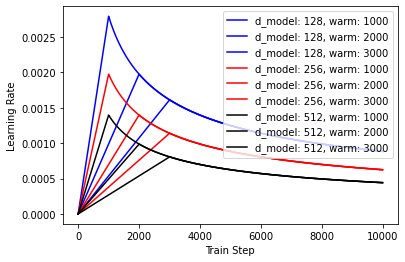

In [75]:
d_models = [128, 256, 512]
warmup_steps = [1000 * i for i in range(1, 4)]

schedules = []
labels = []
colors = ["blue", "red", "black"]
for d in d_models:
  schedules += [CustomSchedule(d, s) for s in warmup_steps]
  labels += [f"d_model: {d}, warm: {s}" for s in warmup_steps]

for i, (schedule, label) in enumerate(zip(schedules, labels)):
  plt.plot(schedule(tf.range(10000, dtype=tf.float32)), 
           label=label, color=colors[i // 3])

plt.legend()

plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [79]:
#開始訓練(並且即時存檔)

transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, dropout_rate)

print(f"""這個 Transformer 有 {num_layers} 層 Encoder / Decoder layers
d_model: {d_model}
num_heads: {num_heads}
dff: {dff}
input_vocab_size: {input_vocab_size}
target_vocab_size: {target_vocab_size}
dropout_rate: {dropout_rate}

""")

這個 Transformer 有 4 層 Encoder / Decoder layers
d_model: 128
num_heads: 8
dff: 512
input_vocab_size: 8115
target_vocab_size: 4207
dropout_rate: 0.1




In [80]:
train_perc = 20
val_prec = 1
drop_prec = 100 - train_perc - val_prec

# 方便比較不同實驗/ 不同超參數設定的結果
run_id = f"{num_layers}layers_{d_model}d_{num_heads}heads_{dff}dff_{train_perc}train_perc"
checkpoint_path = os.path.join(checkpoint_path, run_id)
log_dir = os.path.join(log_dir, run_id)

# tf.train.Checkpoint 可以幫我們把想要存下來的東西整合起來，方便儲存與讀取
# 一般來說你會想存下模型以及 optimizer 的狀態
ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

# ckpt_manager 會去 checkpoint_path 看有沒有符合 ckpt 裡頭定義的東西
# 存檔的時候只保留最近 5 次 checkpoints，其他自動刪除
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# 如果在 checkpoint 路徑上有發現檔案就讀進來
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  
  # 用來確認之前訓練多少 epochs 了
  last_epoch = int(ckpt_manager.latest_checkpoint.split("-")[-1])
  print(f'已讀取最新的 checkpoint，模型已訓練 {last_epoch} epochs。')
else:
  last_epoch = 0
  print("沒找到 checkpoint，從頭訓練。")

沒找到 checkpoint，從頭訓練。


In [81]:
# 為 Transformer 的 Encoder / Decoder 準備遮罩
def create_masks(inp, tar):
  # 英文句子的 padding mask，要交給 Encoder layer 自注意力機制用的
  enc_padding_mask = create_padding_mask(inp)
  
  # 同樣也是英文句子的 padding mask，但是是要交給 Decoder layer 的 MHA 2 
  # 關注 Encoder 輸出序列用的
  dec_padding_mask = create_padding_mask(inp)
  
  # Decoder layer 的 MHA1 在做自注意力機制用的
  # `combined_mask` 是中文句子的 padding mask 跟 look ahead mask 的疊加
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

In [82]:
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function  # 讓 TensorFlow 幫我們將 eager code 優化並加快運算
def train_step(inp, tar):
  # 前面說過的，用去尾的原始序列去預測下一個字的序列
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  # 建立 3 個遮罩
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  # 紀錄 Transformer 的所有運算過程以方便之後做梯度下降
  with tf.GradientTape() as tape:
    # 注意是丟入 `tar_inp` 而非 `tar`。記得將 `training` 參數設定為 True
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    # 跟影片中顯示的相同，計算左移一個字的序列跟模型預測分佈之間的差異，當作 loss
    loss = loss_function(tar_real, predictions)

  # 取出梯度並呼叫前面定義的 Adam optimizer 幫我們更新 Transformer 裡頭可訓練的參數
  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  # 將 loss 以及訓練 acc 記錄到 TensorBoard 上，非必要
  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [83]:
# 定義我們要看幾遍數據集
EPOCHS = 30
print(f"此超參數組合的 Transformer 已經訓練 {last_epoch} epochs。")
print(f"剩餘 epochs：{min(0, last_epoch - EPOCHS)}")


# 用來寫資訊到 TensorBoard，非必要但十分推薦
summary_writer = tf.summary.create_file_writer(log_dir)

# 比對設定的 `EPOCHS` 以及已訓練的 `last_epoch` 來決定還要訓練多少 epochs
for epoch in range(last_epoch, EPOCHS):
  start = time.time()
  
  # 重置紀錄 TensorBoard 的 metrics
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # 一個 epoch 就是把我們定義的訓練資料集一個一個 batch 拿出來處理，直到看完整個數據集 
  for (step_idx, (inp, tar)) in enumerate(train_dataset):
    
    # 每次 step 就是將數據丟入 Transformer，讓它生預測結果並計算梯度最小化 loss
    train_step(inp, tar)  

  # 每個 epoch 完成就存一次檔    
  if (epoch + 1) % 1 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  # 將 loss 以及 accuracy 寫到 TensorBoard 上
  with summary_writer.as_default():
    tf.summary.scalar("train_loss", train_loss.result(), step=epoch + 1)
    tf.summary.scalar("train_acc", train_accuracy.result(), step=epoch + 1)
  
  print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))
  print('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

此超參數組合的 Transformer 已經訓練 0 epochs。
剩餘 epochs：-30


Saving checkpoint for epoch 1 at /content/drive/My Drive/nmt/checkpoints/4layers_128d_8heads_512dff_20train_perc/4layers_128d_8heads_512dff_20train_perc/ckpt-1
Epoch 1 Loss 5.1847 Accuracy 0.0218
Time taken for 1 epoch: 746.7803266048431 secs

Saving checkpoint for epoch 2 at /content/drive/My Drive/nmt/checkpoints/4layers_128d_8heads_512dff_20train_perc/4layers_128d_8heads_512dff_20train_perc/ckpt-2
Epoch 2 Loss 4.2418 Accuracy 0.0605
Time taken for 1 epoch: 651.8076617717743 secs

Saving checkpoint for epoch 3 at /content/drive/My Drive/nmt/checkpoints/4layers_128d_8heads_512dff_20train_perc/4layers_128d_8heads_512dff_20train_perc/ckpt-3
Epoch 3 Loss 3.7414 Accuracy 0.0989
Time taken for 1 epoch: 663.2859191894531 secs

Saving checkpoint for epoch 4 at /content/drive/My Drive/nmt/checkpoints/4layers_128d_8heads_512dff_20train_perc/4layers_128d_8heads_512dff_20train_perc/ckpt-4
Epoch 4 Loss 3.2649 Accuracy 0.1511
Time taken for 1 epoch: 684.8348071575165 secs

Saving checkpoint for ep

In [84]:
# 給定一個英文句子，輸出預測的中文索引數字序列以及注意權重 dict
def evaluate(inp_sentence):
  
  # 準備英文句子前後會加上的 <start>, <end>
  start_token = [subword_encoder_en.vocab_size]
  end_token = [subword_encoder_en.vocab_size + 1]
  
  # inp_sentence 是字串，我們用 Subword Tokenizer 將其變成子詞的索引序列
  # 並在前後加上 BOS / EOS
  inp_sentence = start_token + subword_encoder_en.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # 跟我們在影片裡看到的一樣，Decoder 在第一個時間點吃進去的輸入
  # 是一個只包含一個中文 <start> token 的序列
  decoder_input = [subword_encoder_zh.vocab_size]
  output = tf.expand_dims(decoder_input, 0)  # 增加 batch 維度
  
  # auto-regressive，一次生成一個中文字並將預測加到輸入再度餵進 Transformer
  for i in range(MAX_LENGTH):
    # 每多一個生成的字就得產生新的遮罩
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    

    # 將序列中最後一個 distribution 取出，並將裡頭值最大的當作模型最新的預測字
    predictions = predictions[: , -1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # 遇到 <end> token 就停止回傳，代表模型已經產生完結果
    if tf.equal(predicted_id, subword_encoder_zh.vocab_size + 1):
      return tf.squeeze(output, axis=0), attention_weights
    
    #將 Transformer 新預測的中文索引加到輸出序列中，讓 Decoder 可以在產生
    # 下個中文字的時候關注到最新的 `predicted_id`
    output = tf.concat([output, predicted_id], axis=-1)

  # 將 batch 的維度去掉後回傳預測的中文索引序列
  return tf.squeeze(output, axis=0), attention_weights

In [92]:
!pip3 install opencc-python-reimplemented
clear_output()

In [97]:
from opencc import OpenCC
import json

# Initial
cc = OpenCC('s2t')

TestPath = '/content/drive/MyDrive/translation2019zh/translation2019zh_valid.json'
index = 0
with open(TestPath, 'r') as TestFile:
    for line in TestFile.readlines():
        if index >= 100:
            break
        TestSen = json.loads(line)
        # 取得預測的中文索引序列
        predicted_seq, _ = evaluate(TestSen['english'])
        correct_seq = TestSen['chinese']

        # 過濾掉 <start> & <end> tokens 並用中文的 subword tokenizer 幫我們將索引序列還原回中文句子
        target_vocab_size = subword_encoder_zh.vocab_size
        predicted_seq_without_bos_eos = [idx for idx in predicted_seq if idx < target_vocab_size]
        predicted_sentence = subword_encoder_zh.decode(predicted_seq_without_bos_eos)

        index += 1
        print("第", index, "句")
        print("英文句字:\t", TestSen['english'])
        print("中文翻譯(預測):\t", cc.convert(predicted_sentence))
        print("中文翻譯(正確):\t", cc.convert(correct_seq))
        print("-" * 20)

第 1 句
英文句字:	 Slowly and not without struggle, America began to listen.
中文翻譯(預測):	 不管如此，不再是不會爭奪美國的口頭。
中文翻譯(正確):	 美國緩慢地開始傾聽，但並非沒有艱難曲折。
--------------------
第 2 句
英文句字:	 I didn't own a Thesaurus until four years ago and I use a small Webster's dictionary that I'd bought at K-Mart for 89 cents.
中文翻譯(預測):	 我不能在193年前我們的刑事誹謗之前，我在克服了八小時間裏的刑事犯罪。
中文翻譯(正確):	 直到四年前我纔有了一本詞典。我使用的是用89美分在K市場裏買來的一本韋氏小詞典。我從來不使用單詞處理程序。
--------------------
第 3 句
英文句字:	 portlet, you must write three short deployment descriptors: web.xml, portlet.xml, and geronimo-web.xml. (Some of these may have been generated by your IDE.)
中文翻譯(預測):	 我們必須徹底交易三個方面：一些欺騙、欺騙和賄賂器人員。
中文翻譯(正確):	 portlet 之後，您必須編寫三個簡短的部署描述符：web.xml、portlet.xml 和 geronimo-web.xml（這其中的一些文件可能已經由 IDE 生成）。
--------------------
第 4 句
英文句字:	 Dithering is a technique that blends your colors together, making them look smoother, or just creating interesting textures.
中文翻譯(預測):	 醫療方面是一種能力地區的東西，讓它們轉變其他方式的文化和產品。
中文翻譯(正確):	 抖動是關於顏色混合的技術，使你的作品看起來更圓滑，或者只是創作有趣的材質。
---------------